In [1]:
import sys

import gym
import numpy as np
import scipy.integrate as sc_integrate

import ray
from ray.rllib.algorithms.ppo import PPO

import symbtools as st
import sympy as sp
import pickle
import matplotlib.pyplot as plt

## Mathematical system description with SymPy / symbtools

In [3]:
# load model etc. from pickle of flatness analysis notebook
with open("../flatness_notebooks/single_crane_model.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [4]:
mod.xx

Matrix([
[   p1],
[   p2],
[   q1],
[pdot1],
[pdot2],
[qdot1]])

In [5]:
mod.calc_state_eq(force_recalculation=True)
mod.eqns

Matrix([
[       m2*pddot1 - tau2*(p1 - q1)/sqrt(p2**2 + (p1 - q1)**2)],
[       g*m2 + m2*pddot2 - p2*tau2/sqrt(p2**2 + (p1 - q1)**2)],
[m1*qddot1 - tau1 + tau2*(p1 - q1)/sqrt(p2**2 + (p1 - q1)**2)]])

## Gym environment

In [53]:
from abc import abstractmethod
import inspect
import math
from typing import Optional, Union

import numpy as np
from scipy.integrate import solve_ivp

import gym
from gym import logger, spaces
#from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled
#from gym.utils.renderer import Renderer

class StateSpaceModel(gym.Env):
    """ Environment subclass that uses a state space model of the form dx/dt = f(x, u)
    to represent the environments dynamics.

    Args:
        ode
        cost
        x0
        uDim

    Attributes:
        ode (function): ODE for simulation
        cost (function): cost function (returns scalar)
        o
        o_
        oDim
    """

    def __init__(self, ode, cost, x0, uDim, dt,
                 terminal_cost=0.):
        self.tt = [0]
        self.dt = dt
        if callable(x0):
            self.x0 = x0  # initial state
            x0 = x0()
        else:
            x0 = list(x0)
            self.x0 = x0
        self.x = x0  # current state
        self.x_ = x0 # previous state x[k-1]
        self.xDim = len(x0) # state dimension
        self.uDim = uDim # inputs
        self.o = self.x
        self.o_ = self.x_
        self.oDim = len(self.o)  # observation dimensions
        self.ode = ode
        params = inspect.signature(cost).parameters
        cost_args = params.__len__()
        if cost_args == 1:
            self.cost = lambda x_, u_, x, t, mod: cost(x_)
        elif cost_args == 2:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_)
        elif cost_args == 3:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x)
        elif cost_args == 4:
            if 'mod' in params and 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t, mod)
            elif 'mod' in params and not 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, mod)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, t)
        elif cost_args == 5:
            self.cost = cost
        else:
            print('Cost function must to be of the form c(x_, u_, x, t, mod), where mod is numpy/sympy.')
            assert(True)
            
        self.terminated = False
        self.terminal_cost = terminal_cost
    
    def get_state(self):
        return self.x

    def reset(self):
        """ Resets environment to state x0

        Args:
            x0 (array, list, callable): initial state

        """
        if callable(self.x0):
            x0 = self.x0()
        self.x_ = x0
        self.x = x0
        self.tt = [0]
        self.terminated = False
        return np.array(self.x, dtype=np.float32)

    def step(self, *args):
        """ Simulates the environment for 1 step of time t.

        Args:
            dt (int, float): duration of step (not solver step size)
            u (array): control/action

        Returns:
            c (float): cost of state transition

        """
        self.x_ = self.x  # shift state (x[k-1] = x[k])
        self.o_ = self.o
        if args.__len__()==2:
            u = args[0]
            dt = args[1]
        elif args.__len__() == 1:
            u = args[0]
            dt = self.dt

        # system simulation
        sol = solve_ivp(lambda t, x: self.ode(t, x, u, self.dxdt), (0, dt), self.x_, 'RK45')
        # todo: only output value of the last timestep
        y = list(sol.y[:, -1])  # extract simulation result
        self.x = y
        self.tt.extend([self.tt[-1] + dt])  # increment simulation time
        self.terminated = self.terminate(self.x)
        #x_2pi = mapAngles(self.xIsAngle, self.x_)
        #x2pi = mapAngles(self.xIsAngle, self.x)
        #c = (self.cost(x_2pi, u, x2pi, np) + self.terminal_cost*self.terminated)*dt
        t = self.tt[-1]
        c = (self.cost(self.x_, u, self.x, t, np) + self.terminal_cost * self.terminated) * dt
        
        # todo: place difference for desired value with function or smth here
        self.o =  np.array(self.x, dtype=np.float32)
        reward = -c
        return self.o, reward, self.terminated, {"info": False}
    
    @abstractmethod
    def terminate(self, *args):
        return



class CartPoleEnv(StateSpaceModel):

    metadata = {}

    def __init__(self, cost, x0, dt, mod):
        super(CartPoleEnv, self).__init__(self.ode, cost, x0, 2, dt)
        
        
        F1, F2 = sp.symbols('F1 F2')

        params = sp.symbols('m1, m2, l1, g')
        st.make_global(params)
        params_values = [(m1, 1.0), (m2, 0.1), (l1, 0.5), (g, 9.81)]
        
        states_dot = mod.f + mod.g * sp.Matrix([F1, F2]) ##:
        states_dot_wo_params = states_dot.subs(params_values)
        self.dxdt = st.expr_to_func([*mod.xx, F1, F2], states_dot_wo_params)
        

        # define observation space
        high_obs = np.array(
            [
                100.0,
                100.0,
                100.0,
                100.0,
                100.0,
                100.0
            ],
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high_obs, high_obs, dtype=np.float32)
        
        # define action space
        high_act = np.array(
            [ 
                5.0,
                5.0
            ],
            dtype=np.float32,
        )
        self.action_space = spaces.Box(-high_act, high_act, dtype=np.float32)
    
    def ode(self, t, x, u, dxdt):
        u1 , u2 = u
        states_dot = dxdt(*x, u1, u2-0.981)
        return np.array(states_dot, dtype=np.float32)
    
    def terminate(self, x):
        x1, x2, x3, x4, x5, x6 = x
        if abs(x3) > 50 or abs(x2) > 5 or abs(x1) > 50:
            return True
        else:
            return False

## Cost function, Initial values

In [54]:
mod.xx.T

Matrix([[p1, p2, q1, pdot1, pdot2, qdot1]])

In [58]:
# define the incremental cost
def c_k(x, u):
    x1, x2, x3, x4, x5, x6 = x
    u1, u2 = u
    if abs(x2) < 0.1:
        c = (x2+0.5)**2
    else:
        c = 10*(x2+0.5)**2 #+ (x1-x3)**2 + 0.2*x5**2 + 0.1*x4**2 + 0.1*0.1*x6**2 + 0.1*u1**2
    return c

# define the function, that represents the initial value distribution p(x_0)
def p_x0():
    x0 = [
            0, 
            -0.5, 
            0, 
            0,
            0,
            0
    ]
    return x0

t = 10 # time of an episode
dt = 0.05 # time step-size
learning_steps = int(1e5) # define training duration

## Create Gym env

In [38]:
# environment without renderings for training
env = CartPoleEnv(c_k, p_x0, dt, mod)

In [39]:
env.reset()
env.step(env.action_space.sample())
env.observation_space

Box([-100. -100. -100. -100. -100. -100.], [100. 100. 100. 100. 100. 100.], (6,), float32)

## Configure RL algo

In [15]:
ray.init()

2022-09-09 13:20:30,525	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.0.0


In [41]:
from ray.tune.registry import register_env

def env_creator(env_config):
    return CartPoleEnv(**env_config) # return an env instanceregister_env("my_env", env_creator)

In [42]:
register_env("CartPoleCustom", env_creator)

In [48]:
config = {
    # Environment (RLlib understands openAI gym registered strings).
    "env": "CartPoleCustom",
    "env_config": {"cost":c_k, "x0":p_x0, "dt":dt, "mod":mod},
    # Use 2 environment workers (aka "rollout workers") that parallelly
    # collect samples from their own environment clone(s).
    "num_workers": 2,
    # Change this to "framework: torch", if you are using PyTorch.
    # Also, use "framework: tf2" for tf2.x eager execution.
    "framework": "tf",
    # Tweak the default model provided automatically by RLlib,
    # given the environment's observation- and action spaces.
    "model": {
        "fcnet_hiddens": [64, 64],
        "fcnet_activation": "relu",
    },
    # Set up a separate evaluation worker set for the
    # `algo.evaluate()` call after training (see below).
    "evaluation_num_workers": 1,
    # Only for evaluation runs, render the env.
    "evaluation_config": {
        "render_env": False,
    },
}


## Training the model

In [60]:
algo = PPO(config=config)

2022-09-09 14:52:43,826	WARNING algorithm.py:2099 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


(RolloutWorker pid=4055) ]0;IPython: SA-Wrede/reinforcement_learning_control
(RolloutWorker pid=4056) ]0;IPython: SA-Wrede/reinforcement_learning_control


(RolloutWorker pid=4055) 2022-09-09 14:52:47,441	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-09 14:52:48,592	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-09-09 14:52:48,593	WARNING algorithm.py:2099 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


(RolloutWorker pid=4123) ]0;IPython: SA-Wrede/reinforcement_learning_control


(RolloutWorker pid=4123) 2022-09-09 14:52:51,725	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-09 14:52:52,299	WARNING util.py:65 -- Install gputil for GPU system monitoring.


In [61]:
for _ in range(learning_steps):
    algo.train()

KeyboardInterrupt: 

In [62]:
algo.evaluate()

KeyboardInterrupt: 

## Testing the model

In [66]:
algo.compute_single_action?

In [52]:
u1_for_plots = []
u2_for_plots = []
x1_for_plots = []
x2_for_plots = []
x3_for_plots = []

obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    u1_for_plots = np.append(u1_for_plots, action[0])
    u2_for_plots = np.append(u2_for_plots, action[1])
    x1_for_plots = np.append(x1_for_plots, obs[0])
    x2_for_plots = np.append(x2_for_plots, obs[1])
    x3_for_plots = np.append(x3_for_plots, obs[2])
    if done:
      obs = env.reset()
      break;

NameError: name 'model' is not defined

## Plotting

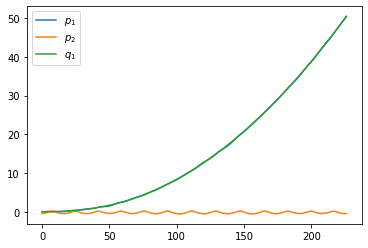

In [127]:
plt.plot(x1_for_plots, label=r"$p_1$")
plt.plot(x2_for_plots, label=r"$p_2$")
plt.plot(x3_for_plots, label=r"$q_1$")
plt.legend()

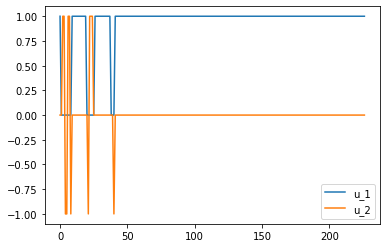

In [126]:
plt.plot(u1_for_plots-1, label=r"u_1")
plt.plot(u2_for_plots-1, label=r"u_2")
plt.legend()